In [1]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='0'

# import shutups
# shutup.please()

import jax
import jax.numpy as jnp

import numpy as np
from functools import partial

# VIS
import matplotlib
import matplotlib.pyplot as plt
import mediapy
from rich.pretty import pprint
from tqdm.auto import tqdm

from envs.minigrid.doors_grid import ActionRepeatWrapper
from hydra import initialize, compose
from omegaconf import OmegaConf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-notebook'])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

GLOBAL_KEY = jax.random.key(42)

# Multiple Doors

,,,

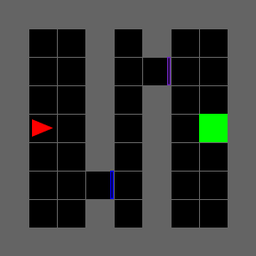
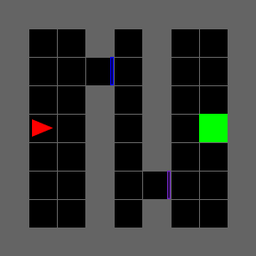
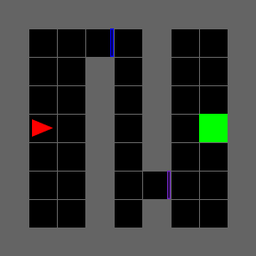
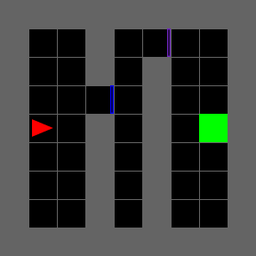

In [2]:
from envs.minigrid.doors_grid import DynamicsGeneralization_Doors, MinigridWrapper

# Train dynamics
layouts = []
for i in [0, 1, 2, 3]:
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=100, task_num=0)
    env._gen_grid = partial(env._gen_grid, layout_type=i)
    env = MinigridWrapper(env)
    # env = ActionRepeatWrapper(env, action_repeat=3) # test
    env.reset()
    
    layouts.append(env.render())
    
mediapy.show_images(layouts, width=256, height=256)

  0%|          | 0/4 [00:00<?, ?it/s]

{
│   'actions': (198000,),
│   'layout_type': (198000, 3),
│   'next_observations': (198000, 2),
│   'observations': (198000, 2),
│   'terminals': (198000,)
}

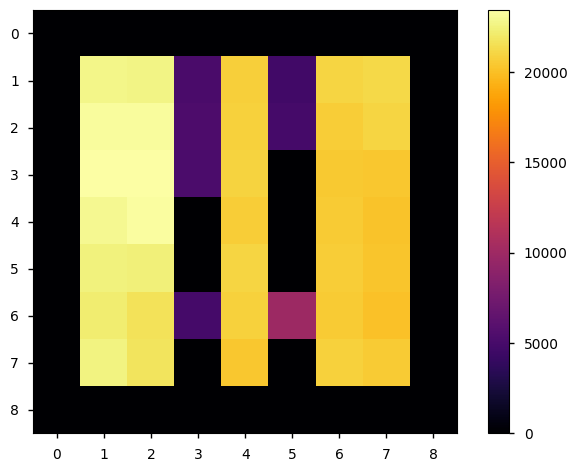

In [3]:
from envs.minigrid.env_utils import q_learning

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

def random_exploration(env, num_episodes: int, layout_type: int, num_mdp: int):
    dataset = dict()
    observations = []
    actions = []
    dones = []
    next_observations = []
    
    for _ in range(num_episodes):
        obs, _ = env.reset()
        cur_observations = []
        cur_actions = []
        cur_dones = []
        cur_next_observations = []
        done = False
        step = 0
        cur_action_num = 0
        while not done and step < env.env.unwrapped.max_steps:
            step += 1
            cur_observations.append(np.array(obs, dtype=np.float32))
            #if cur_action_num > 4 or step == 1:
            action = env.action_space.sample()
            #    cur_action_num = 0
            #cur_action_num += 1
            next_state, reward, terminated, truncated, info = env.step(action)
            cur_next_observations.append(np.array(next_state, dtype=np.float32))
            cur_actions.append(np.array(action, dtype=np.float32))
            done = truncated# or terminated
            obs = next_state
            cur_dones.append(np.array(done, dtype=np.float32))
            
        observations.append(np.stack(cur_observations)) # seq_len x dim
        actions.append(np.stack(cur_actions))
        dones.append(np.stack(cur_dones))
        next_observations.append(np.stack(cur_next_observations))
        
    dataset['observations'] = np.concatenate(observations)
    dataset['terminals'] = np.concatenate(dones)
    dataset['actions'] = np.concatenate(actions)
    dataset['next_observations'] = np.concatenate(next_observations)
    
    ob_mask = (1.0 - dataset['terminals']).astype(bool)
    # next_ob_mask = np.concatenate([[False], ob_mask[:-1]])
    # dataset['next_observations'] = dataset['observations'][next_ob_mask]
    dataset['next_observations'] = dataset['next_observations'][ob_mask]
    dataset['observations'] = dataset['observations'][ob_mask]
    dataset['actions'] = dataset['actions'][ob_mask].astype(np.int8)
    new_terminals = np.concatenate([dataset['terminals'][1:], [1.0]])
    dataset['terminals'] = new_terminals[ob_mask].astype(np.float32)
    #np.tile(layout_type, reps=(dataset['actions'].shape[0], 1)) #n
    dataset['layout_type'] = np.tile(layout_type, reps=(dataset['actions'].shape[0], 1)) #np.tile(one_hot(np.array(layout_type), num_mdp), reps=(dataset['actions'].shape[0], 1))
    return dataset, env

train_layout_data = []

# NUM_TRAIN_LAYOUTS = 3
# NUM_TRAIN_STEPS = 100
# NUM_TRAIN_EPISODES = 1000

# for i in tqdm(range(NUM_TRAIN_LAYOUTS)):
#     env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=NUM_TRAIN_STEPS)#, agent_start_pos=None) # comment agent_start_pos for same start pos
#     env._gen_grid = partial(env._gen_grid, layout_type=i)
#     env = MinigridWrapper(env)
#     # dataset, env = random_exploration(env, num_episodes=NUM_TRAIN_EPISODES, layout_type=i, num_mdp=NUM_TRAIN_LAYOUTS)
#     dataset, env = q_learning(env, num_episodes=NUM_TRAIN_EPISODES, layout_type=i, epsilon=0.75, num_mdp=NUM_TRAIN_LAYOUTS)
#     train_layout_data.append(dataset)

NUM_TRAIN_LAYOUTS = 4
NUM_TRAIN_STEPS = 100
NUM_TRAIN_EPISODES = 2000

# for debug
layout_types = np.array([[1, 1, 0], [1, 0, 1], [1, 1, 1], [1, -1, 1]])
# layout_types = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 1]])
# layout_types = np.array([[1, 0, 1], [1, -np.sqrt(2), 1], [1, np.sqrt(2), 1]])
# layout_types = np.array([[1, 1, 0], [1, -1, 1], [-1, 1, 2]])

for i in tqdm(range(NUM_TRAIN_LAYOUTS)):
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=NUM_TRAIN_STEPS, agent_start_pos=None) # comment agent_start_pos for same start pos
    env._gen_grid = partial(env._gen_grid, layout_type=i)
    env = MinigridWrapper(env)
    dataset, env = random_exploration(env, num_episodes=NUM_TRAIN_EPISODES, layout_type=layout_types[i], num_mdp=NUM_TRAIN_LAYOUTS) #layout_types[i]
    train_layout_data.append(dataset)

pprint(jax.tree.map(lambda x: x.shape, train_layout_data[0]))

coverage_map = np.zeros(shape=(env.env.unwrapped.width, env.env.unwrapped.height))
for layout in train_layout_data:
    for obs in layout['observations']:
        obs = obs.astype(np.int16)
        coverage_map[obs[1], obs[0]] += 1
        
plt.imshow(coverage_map, cmap='inferno', vmin=0)
plt.colorbar()
plt.show()

# Train Dynamics-Aware FB

In [4]:
import functools
from utils.datasets import Dataset, GCDataset

with initialize(version_base=None, config_path="../configs/"):
    fb_config = compose(config_name='entry.yaml', overrides=['experiment=fb_dynamics_discrete_doors_onehot.yaml',
                                                            f'agent.number_of_meta_envs={NUM_TRAIN_LAYOUTS}'])
    fb_config = OmegaConf.to_container(fb_config, resolve=True)
    pprint(fb_config)

def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

whole_data = functools.reduce(concatenate_dicts, train_layout_data)
# SAVING
# np.save(f"../aux_data/doors_meta{NUM_TRAIN_LAYOUTS}_data", arr=jax.device_get(whole_data))
# whole_data = np.load(f"/home/m_bobrin/ZeroShotRL/aux_data/doors_meta{NUM_TRAIN_LAYOUTS}_data.npy", allow_pickle=True).item()

print(jax.tree.map(lambda x: x.shape, whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))
gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])

{
│   'seed': 42,
│   'run_group': 'dynamics_fb',
│   'save_dir': 'experiment_logs/',
│   'train_steps': 400000,
│   'log_interval': 10000,
│   'eval_interval': 50000,
│   'eval_tasks': None,
│   'eval_episodes': 20,
│   'eval_temperature': 0,
│   'eval_gaussian': None,
│   'video_episodes': 1,
│   'video_frame_skip': 3,
│   'eval_on_cpu': 0,
│   'frame_stack': None,
│   'p_aug': None,
│   'agent': {
│   │   'agent_name': 'dynamics_fb',
│   │   'lr': 0.0003,
│   │   'batch_size': 1024,
│   │   'discrete': True,
│   │   'discount': 0.99,
│   │   'tau': 0.01,
│   │   'clip_by_global_norm': True,
│   │   'dataset_class': 'GCDataset',
│   │   'value_p_curgoal': 0.0,
│   │   'value_p_trajgoal': 1.0,
│   │   'value_p_randomgoal': 0.0,
│   │   'value_geom_sample': True,
│   │   'actor_p_curgoal': 0.0,
│   │   'actor_p_trajgoal': 0.0,
│   │   'actor_p_randomgoal': 1.0,
│   │   'actor_geom_sample': False,
│   │   'gc_negative': True,
│   │   'p_aug': 0.0,
│   │   'frame_stack': None,
│   │   'z_dim': 100,
│   │   'z_mix_ratio': 0.5,
│   │   'boltzmann': True,
│   │   'one_hot_dim': 3,
│   │   'f_hidden_dims': [1024, 512, 512],
│   │   'f_layer_norm': True,
│   │   'b_hidden_dims': [512, 512, 512],
│   │   'b_layer_norm': True,
│   │   'use_context': False,
│   │   'number_of_meta_envs': 4
│   },
│   'env': {'env_name': 'fourrooms-dynamics', 'discrete': True},
│   'tags': ['dynamics-fb', 'doors', 'discrete']
}

{'actions': (792000,), 'layout_type': (792000, 3), 'next_observations': (792000, 2), 'observations': (792000, 2), 'terminals': (792000,)}


In [5]:
sys.path.append("..")
# from agents.dynamics_fb import ForwardBackwardAgent
# ONLY FOR TESTING
from agents.dynamics_fb_onehot import ForwardBackwardAgent

gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])
example_batch = gc_whole_dataset.sample(1)
fb_agent = ForwardBackwardAgent.create(
    0,
    example_batch['observations'],
    np.full_like(example_batch['actions'], env.action_space.n - 1),
    config=fb_config['agent']
)
batch = gc_whole_dataset.sample(2, layout_type=None, context_length=NUM_TRAIN_STEPS, get_traj_batch=True)[1]
# with jax.disable_jit():
fb_agent, info = fb_agent.update(batch, train_context_embedding=False)

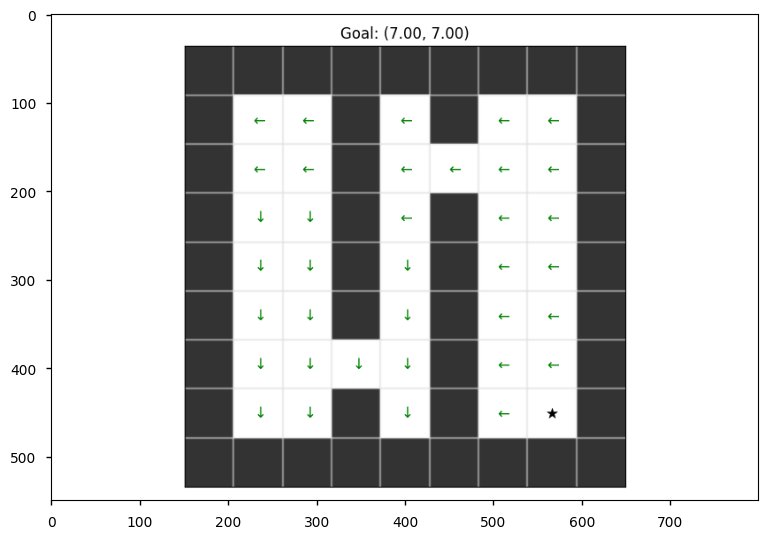

In [6]:
from functools import partial
from utils.evaluation import supply_rng
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def get_canvas_image(canvas):
    canvas.draw() 
    out_image = np.asarray(canvas.buffer_rgba())
    return out_image

def policy_image_grid(env, dataset, action_fn=None, **kwargs):
    fig = plt.figure(tight_layout=True)
    canvas = FigureCanvas(fig)
    plot_policy(env, dataset, fig=fig, ax=plt.gca(), action_fn=action_fn, **kwargs)
    image = get_canvas_image(canvas)
    plt.close(fig)
    return image

def plot_policy(env, dataset, fig=None, ax=None, title=None, action_fn=None, **kwargs):
    action_names = [
            r'$\leftarrow$', r'$\rightarrow$', r'$\uparrow$', r'$\downarrow$'
        ]
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    grid = env.get_grid_array()
    ax = env.plot_grid(ax=ax, grid=grid)
    
    goal = kwargs.get('goal', None)
    for (y, x), value in np.ndenumerate(grid):
        if value == 1 or value == 4:
            action = action_fn(np.concatenate([[x], [y]], -1)).squeeze()
            action_name = action_names[action]
            ax.text(x, y, action_name, ha='center', va='center', fontsize='large', color='green')
            
    ax.set_title('Goal: ({:.2f}, {:.2f})'.format(goal[0], goal[1]))
    ax.scatter(goal[0], goal[1], s=80, c='black', marker='*')
        
    if title:
        ax.set_title(title)
        
    return fig, ax

def visualize_policy_image(layout_type, task_num):
    # mdp_type = layout_types[layout_type]
    # mdp_type = np.zeros((NUM_TRAIN_LAYOUTS, ))
    # if mdp_type is not None:
    #     if layout_type == 0:
    #         mdp_type[0] = 1
    #     elif layout_type == 1:
    #         mdp_type[1] = 1
    #     else:
    #         mdp_type[2] = 1
    mdp_type = layout_types[layout_type]
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False,
                                    max_steps=NUM_TRAIN_STEPS, task_num=task_num)
    env._gen_grid = partial(env._gen_grid, layout_type=layout_type)
    env = MinigridWrapper(env)
    obs, info = env.reset()
    goal = info.get("goal_pos", None)
    latent_z = fb_agent.infer_z(goal, mdp_num=mdp_type, dynamics_embedding=None)
    example_batch = gc_whole_dataset.sample(1)
    pred_policy_img = policy_image_grid(env, example_batch,
                                                    action_fn=partial(supply_rng(fb_agent.sample_actions,
                                                                                rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z,
                                                                    mdp_num=mdp_type[None], dynamics_embedding=None, temperature=0.0),
                                                    goal=goal)
    return pred_policy_img

pred_policy_img = visualize_policy_image(layout_type=0, task_num=2)
plt.imshow(pred_policy_img)
plt.tight_layout()

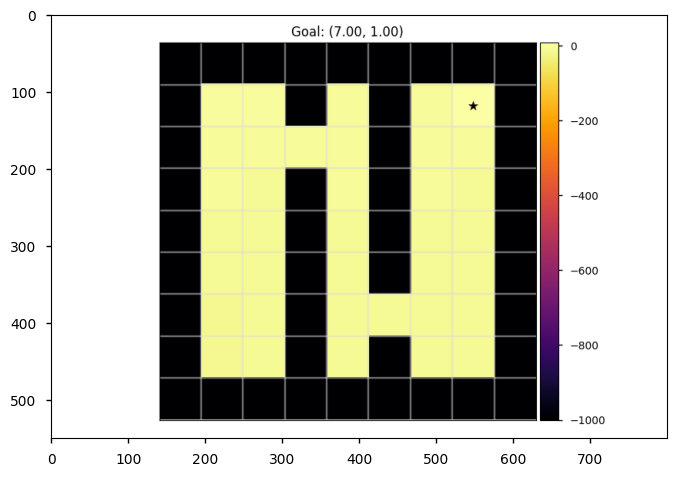

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def value_image_fourrooms(env, dataset, value_fn, action_fn=None, **kwargs):
    fig = plt.figure(tight_layout=True)
    canvas = FigureCanvas(fig)
    plot_value_image_grid(env, dataset, value_fn, fig=fig, ax=plt.gca(), action_fn=action_fn, **kwargs)
    image = get_canvas_image(canvas)
    plt.close(fig)
    return image

def plot_value_image_grid(env, dataset, value_fn, action_fn, fig=None, ax=None, title=None, **kwargs):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    goal = kwargs.get('goal', None)
    grid = env.get_grid_array()
    ax = env.plot_grid(ax=ax, grid=grid)

    for (y, x), value in np.ndenumerate(grid):
        if value == 1 or value == 4:
            grid[y, x] = jax.device_get(value_fn(np.concatenate([[x], [y]], -1)).max(-1)[0])
            
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(grid, cmap='inferno', vmin=-1000)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if goal is not None:
        ax.set_title('Goal: ({:.2f}, {:.2f})'.format(goal[0], goal[1])) 
        ax.scatter(goal[0], goal[1], s=80, c='black', marker='*')
    return fig, ax

def visualize_value_image(layout_type, task_num):
    # mdp_type = layout_types[layout_type]
    # mdp_type = np.zeros((NUM_TRAIN_LAYOUTS, ))
    # if mdp_type is not None:
    #     if layout_type == 0:
    #         mdp_type[0] = 1
    #     elif layout_type == 1:
    #         mdp_type[1] = 1
    #     else:
    #         mdp_type[2] = 1
    mdp_type = layout_types[layout_type]
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False,
                                    max_steps=NUM_TRAIN_STEPS, task_num=task_num)
    env._gen_grid = partial(env._gen_grid, layout_type=layout_type)
    env = MinigridWrapper(env)
    dynamics_embedding=None
    obs, info = env.reset()
    goal = info.get("goal_pos", None)
    latent_z = jax.device_get(fb_agent.infer_z(goal, mdp_num=mdp_type, dynamics_embedding=None)[None])
    pred_value_img = value_image_fourrooms(env, example_batch,
                                value_fn=partial(fb_agent.predict_q, z=latent_z, mdp_num=mdp_type[None] if mdp_type is not None else None,
                                                dynamics_embedding=None),
                                action_fn=None, goal=goal)
    return pred_value_img

pred_value_img = visualize_value_image(1, task_num=1)
plt.imshow(pred_value_img)


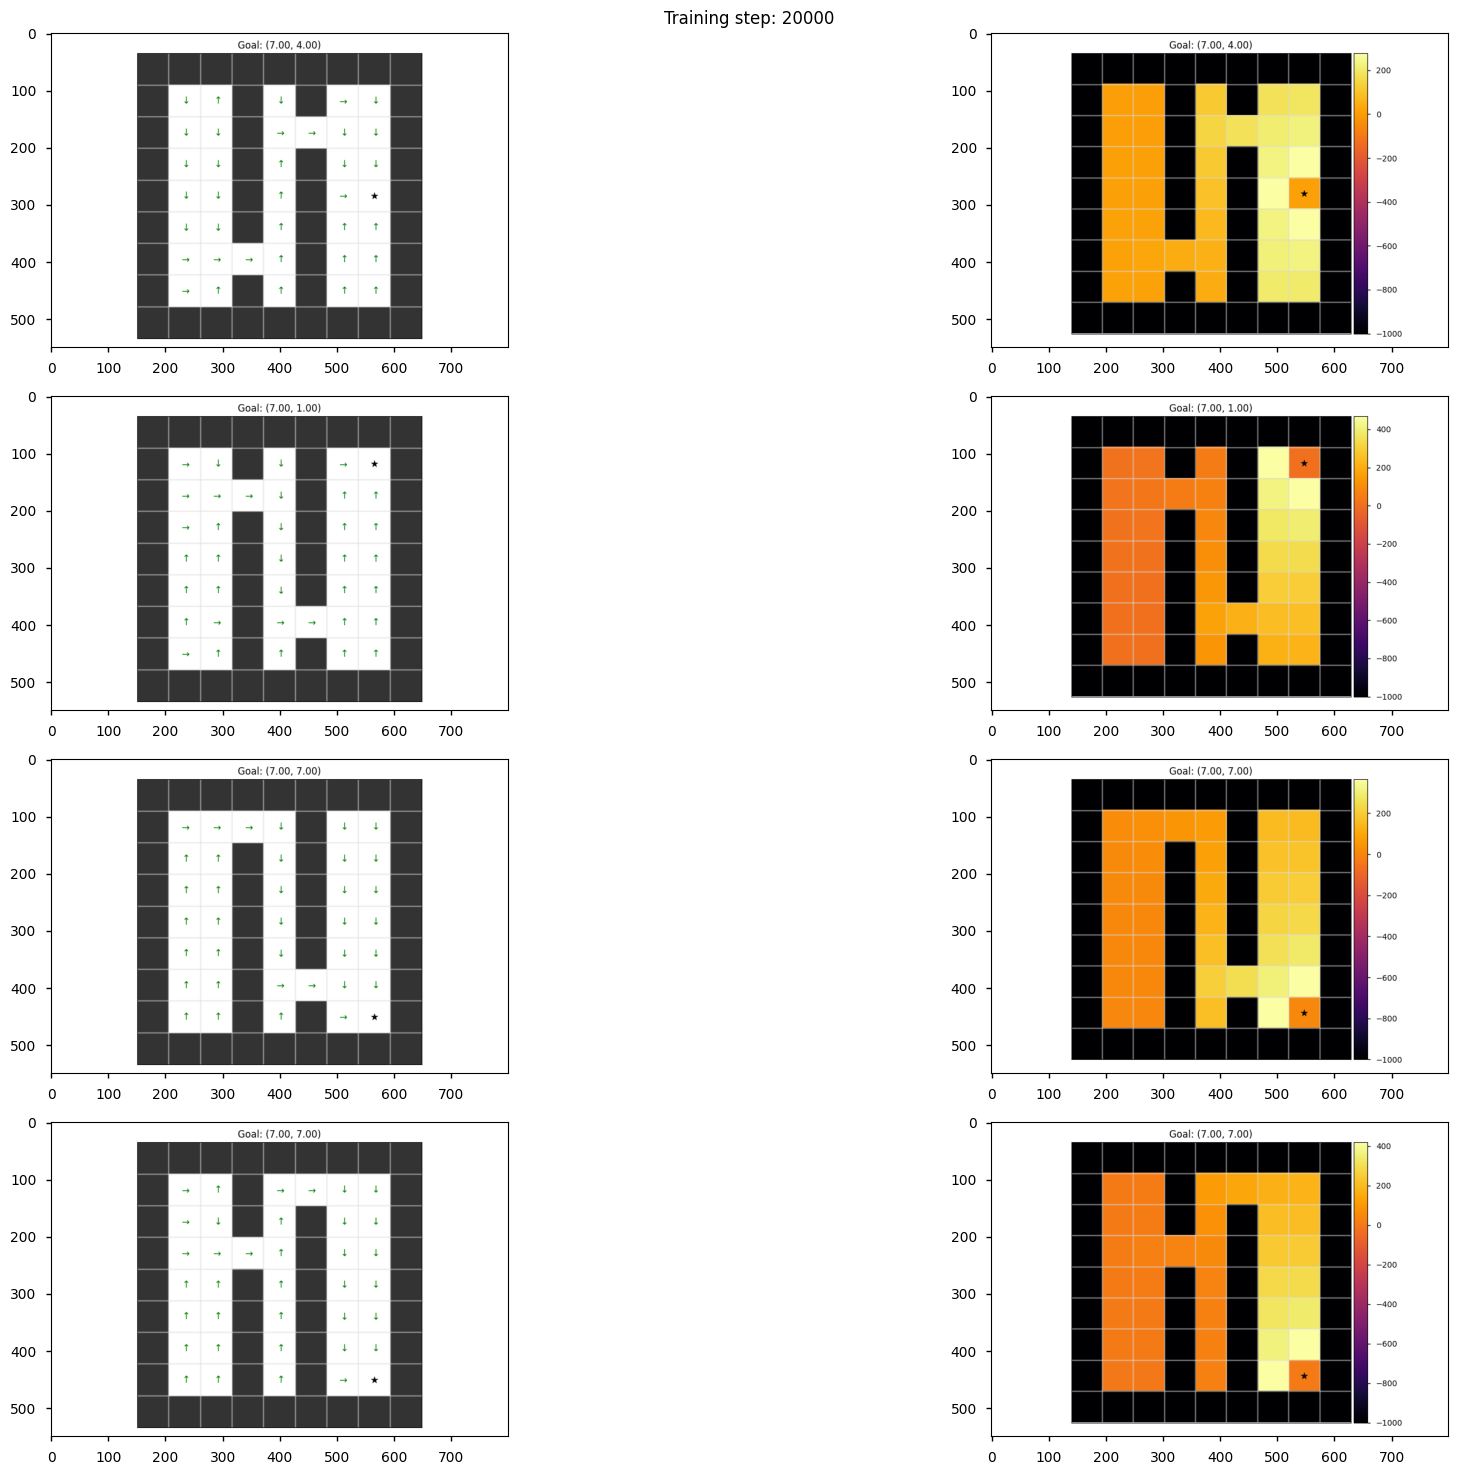

KeyboardInterrupt: 

In [188]:
from IPython.display import clear_output
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def pairwise_distances(dist, xs, ys):
    return jax.vmap(lambda x: jax.vmap(lambda y: dist(x, y))(xs))(ys)

obs, info = env.reset()
goal = info.get("goal_pos")

plot_layouts = []
for i in range(NUM_TRAIN_LAYOUTS):
    cur_layout = gc_whole_dataset.sample(512, layout_type=None, custom_layout=layout_types[i], get_traj_batch=True, context_length=NUM_TRAIN_STEPS)[1]
    plot_layouts.append(cur_layout)
    
plot_layouts = functools.reduce(concatenate_dicts, plot_layouts)

cmap = matplotlib.colormaps['Set1']
c = cmap(np.linspace(0, 1, 7)) # number of doors
layouts_for_embeddings = []
colors = []
for i in range(1, 7):
    cur_layout_indx = jnp.where(jnp.any((plot_layouts['traj_states'][:, :, 0] == 3.0) & (plot_layouts['traj_states'][:, :, 1] == i), 1))[0]
    cur_layout_traj = jax.tree_util.tree_map(lambda arr: arr[cur_layout_indx], plot_layouts)
    if len(cur_layout_indx) > 1:
        layouts_for_embeddings.append(cur_layout_traj)
        colors.append([c[i]] * cur_layout_traj['traj_actions'].shape[0])
plot_layouts = functools.reduce(concatenate_dicts, layouts_for_embeddings)
colors = np.concatenate(colors)

pbar = tqdm(range(50_000))
for update_step in pbar:
    key = jax.random.fold_in(GLOBAL_KEY, update_step)
    batch = gc_whole_dataset.sample(fb_config['agent']['batch_size'], layout_type=None, context_length=NUM_TRAIN_STEPS, get_traj_batch=True)[1]
    fb_agent, info = fb_agent.update(batch, train_context_embedding=False)
    
    if update_step % 5_000 == 0:
        clear_output()
        fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(23, 15))

        pred_policy_img = visualize_policy_image(layout_type=0, task_num=0)
        ax[0,0].imshow(pred_policy_img)
        pred_value_img = visualize_value_image(layout_type=0, task_num=0)
        ax[0, 1].imshow(pred_value_img)
        
        pred_policy_img = visualize_policy_image(layout_type=1, task_num=1)
        ax[1,0].imshow(pred_policy_img)
        
        pred_value_img = visualize_value_image(layout_type=1, task_num=1)
        ax[1, 1].imshow(pred_value_img)
        
        pred_policy_img = visualize_policy_image(layout_type=2, task_num=2)
        ax[2,0].imshow(pred_policy_img)

        pred_value_img = visualize_value_image(layout_type=2, task_num=2)
        ax[2, 1].imshow(pred_value_img)
        
        pred_policy_img = visualize_policy_image(layout_type=3, task_num=2)
        ax[3,0].imshow(pred_policy_img)

        pred_value_img = visualize_value_image(layout_type=3, task_num=2)
        ax[3, 1].imshow(pred_value_img)
        
        
        fig.suptitle(f"Training step: {update_step}")
        plt.tight_layout()
        display(fig)
        plt.close(fig)

/tmp/ipykernel_3518067/1495134282.py:58: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(z_pres[i,:, 0], z_pres[i,:, 1], z_pres[i, :, 2], alpha=0.6, c=z_colors[i])#c[i])


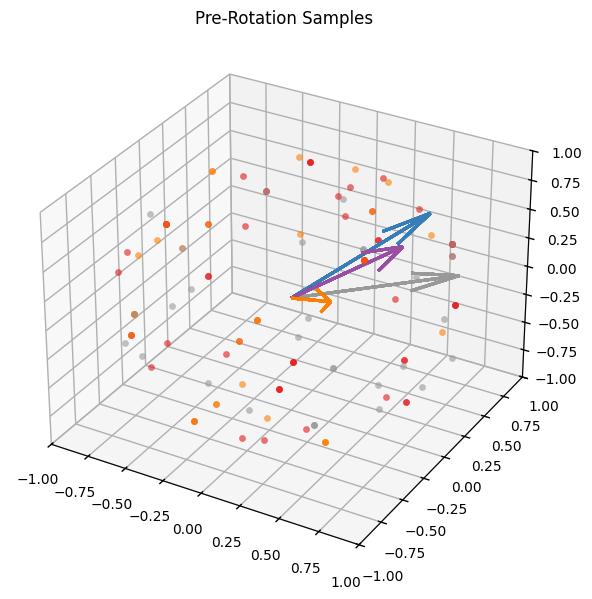

In [189]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Visualization for 3D case
def visualize_3d(z_pre, z_post, anchor):
    fig = plt.figure(figsize=(12, 6))
    
    # Pre-rotation
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(z_pre[:,0], z_pre[:,1], z_pre[:,2], alpha=0.6)
    ax1.quiver(0, 0, 0, 1, 0, 0, color='r', lw=2, label='Original Direction')
    ax1.set_title('Pre-Rotation Samples')
    ax1.set_xlim(-1,1); ax1.set_ylim(-1,1); ax1.set_zlim(-1,1)
    
    # Post-rotation
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(z_post[:,0], z_post[:,1], z_post[:,2], alpha=0.6, c='orange')
    # ax2.quiver(0, 0, 0, *anchor, color='g', lw=2, label='Target Anchor')
    ax2.set_title(f'Post-Rotation Samples (κ=50)')
    ax2.set_xlim(-1,1); ax2.set_ylim(-1,1); ax2.set_zlim(-1,1)
    
    plt.tight_layout()
    plt.show()
    
def get_colors_by_composite_labels(labels: np.ndarray):
    """
    Assign colors based on composite labels (arrays of size 3).
    Each unique combination of 3 values gets the same color.
    
    Args:
        labels: numpy array of shape (batch, 3) where each row is a composite label
        
    Returns:
        List of color strings in hex format
    """
    cmap = matplotlib.colormaps['Set1']
    color_palette = cmap(np.linspace(0, 1, 3)) # number of doors
    
    # Convert each composite label to a tuple (hashable) for dictionary keys
    label_tuples = [tuple(label) for label in labels]
    unique_labels = list(set(label_tuples))  # Get unique composite labels
    
    # Create mapping from composite label to color
    label_to_color = {label: color_palette[i % len(color_palette)] 
                    for i, label in enumerate(unique_labels)}
    
    # Generate color array
    colors = [label_to_color[tuple(label)] for label in labels]
    
    return colors

def visualize_dynamics(z_pres, z_posts, anchor, z_colors, colors):
    fig = plt.figure(figsize=(12, 6))
    anchor = (anchor / jnp.linalg.norm(anchor, axis=-1, keepdims=True))
    ax1 = fig.add_subplot(111, projection='3d')
    for i in range(z_pres.shape[0]):
        ax1.scatter(z_pres[i,:, 0], z_pres[i,:, 1], z_pres[i, :, 2], alpha=0.6, c=z_colors[i])#c[i])
    for i in range(1, colors.shape[0]):
        ax1.quiver(0, 0, 0, *anchor[i], color=colors[i], lw=2)
    ax1.set_title('Pre-Rotation Samples')
    ax1.set_xlim(-1,1); ax1.set_ylim(-1,1); ax1.set_zlim(-1,1)
    
    plt.tight_layout()
    plt.show()

final_indices = np.cumsum(jnp.array([layouts_for_embeddings[i]['traj_states'].shape[0] for i in range(0, len(layouts_for_embeddings))]))
samples_from_trajs = []
prev_inxs = 0
for i in range(len(final_indices)):
    cur_sel = np.random.choice(np.arange(prev_inxs, final_indices[i]), size=30)
    samples_from_trajs.append(cur_sel)
    prev_inxs = final_indices[i] + 1
    
samples_from_trajs_indxs = np.stack(samples_from_trajs).reshape(-1)
    
key = jax.random.PRNGKey(0)
one_hot_labels = np.concatenate([layouts_for_embeddings[i]['layout_type'] for i in range(NUM_TRAIN_LAYOUTS)])
obses = np.concatenate([layouts_for_embeddings[i]['observations'] for i in range(NUM_TRAIN_LAYOUTS)])
next_obses = np.concatenate([layouts_for_embeddings[i]['next_observations'] for i in range(NUM_TRAIN_LAYOUTS)])
actions = np.concatenate([layouts_for_embeddings[i]['actions'] for i in range(NUM_TRAIN_LAYOUTS)])[:, None]

tsne = one_hot_labels[samples_from_trajs_indxs]
# z = fb_agent.sample_mixed_z(batch, fb_config['agent']['z_dim'], GLOBAL_KEY)
z = fb_agent.network.select('b_value')(obses[samples_from_trajs_indxs])#, one_hot_labels) # GOALS goal[None]
# z, _ = fb_agent.network.select('f_value')(obses, jnp.repeat(z, repeats=obses.shape[0], axis=0), one_hot_labels)
# z = np.argmax(z, axis=-1)
z = TSNE(3, random_state=42).fit_transform(z)
z = (z / jnp.linalg.norm(z, axis=-1)[:, None])[:, None]
z_colors = get_colors_by_composite_labels(one_hot_labels[samples_from_trajs_indxs])
visualize_dynamics(z, z, tsne, z_colors, colors=colors[samples_from_trajs_indxs])

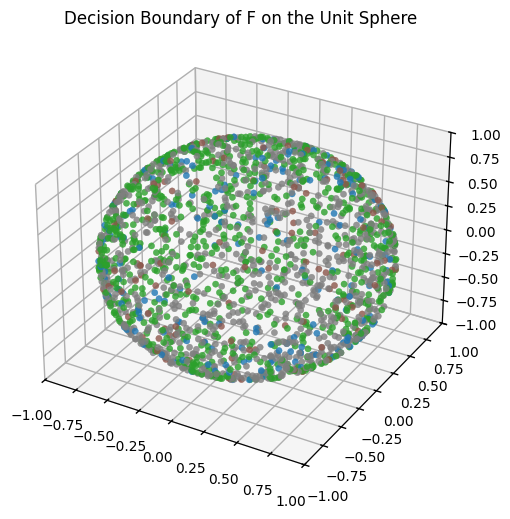

In [195]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Visualization for 3D case
def visualize_3d(z_pre, z_post, anchor):
    fig = plt.figure(figsize=(12, 6))
    
    # Pre-rotation
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(z_pre[:,0], z_pre[:,1], z_pre[:,2], alpha=0.6)
    ax1.quiver(0, 0, 0, 1, 0, 0, color='r', lw=2, label='Original Direction')
    ax1.set_title('Pre-Rotation Samples')
    ax1.set_xlim(-1,1); ax1.set_ylim(-1,1); ax1.set_zlim(-1,1)
    
    # Post-rotation
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(z_post[:,0], z_post[:,1], z_post[:,2], alpha=0.6, c='orange')
    # ax2.quiver(0, 0, 0, *anchor, color='g', lw=2, label='Target Anchor')
    ax2.set_title(f'Post-Rotation Samples (κ=50)')
    ax2.set_xlim(-1,1); ax2.set_ylim(-1,1); ax2.set_zlim(-1,1)
    
    plt.tight_layout()
    plt.show()
    
def get_colors_by_composite_labels(labels: np.ndarray):
    """
    Assign colors based on composite labels (arrays of size 3).
    Each unique combination of 3 values gets the same color.
    
    Args:
        labels: numpy array of shape (batch, 3) where each row is a composite label
        
    Returns:
        List of color strings in hex format
    """
    cmap = matplotlib.colormaps['Set1']
    color_palette = cmap(np.linspace(0, 1, 3)) # number of doors
    
    # Convert each composite label to a tuple (hashable) for dictionary keys
    label_tuples = [tuple(label) for label in labels]
    unique_labels = list(set(label_tuples))  # Get unique composite labels
    
    # Create mapping from composite label to color
    label_to_color = {label: color_palette[i % len(color_palette)] 
                    for i, label in enumerate(unique_labels)}
    
    # Generate color array
    colors = [label_to_color[tuple(label)] for label in labels]
    
    return colors

def visualize_dynamics(z_pres, z_posts, anchor, z_colors, colors):
    fig = plt.figure(figsize=(12, 6))
    anchor = (anchor / jnp.linalg.norm(anchor, axis=-1, keepdims=True))
    ax1 = fig.add_subplot(111, projection='3d')
    for i in range(z_pres.shape[0]):
        ax1.scatter(z_pres[i,:, 0], z_pres[i,:, 1], z_pres[i, :, 2], alpha=0.6, c=z_colors[i])#c[i])
    for i in range(1, colors.shape[0]):
        ax1.quiver(0, 0, 0, *anchor[i], color=colors[i], lw=2)
    ax1.set_title('Pre-Rotation Samples')
    ax1.set_xlim(-1,1); ax1.set_ylim(-1,1); ax1.set_zlim(-1,1)
    
    plt.tight_layout()
    plt.show()

def project_z(z):
    return z / jnp.linalg.norm(z, axis=-1, keepdims=True)

def sample_z(batch_size, latent_dim, key):
    z = jax.random.normal(shape=(batch_size, latent_dim), key=key)
    return z

layouts_to_viz = 1

final_indices = np.cumsum(jnp.array([layouts_for_embeddings[i]['traj_states'].shape[0] for i in range(layouts_to_viz)]))
samples_from_trajs = []
prev_inxs = 0
for i in range(len(final_indices)):
    cur_sel = np.random.choice(np.arange(prev_inxs, final_indices[i]), size=35)
    samples_from_trajs.append(cur_sel)
    prev_inxs = final_indices[i] + 1
    
samples_from_trajs_indxs = np.stack(samples_from_trajs).reshape(-1)
    
key = jax.random.PRNGKey(0)
one_hot_labels = np.concatenate([layouts_for_embeddings[i]['layout_type'] for i in range(NUM_TRAIN_LAYOUTS)])
obses = np.concatenate([layouts_for_embeddings[i]['observations'] for i in range(NUM_TRAIN_LAYOUTS)])
next_obses = np.concatenate([layouts_for_embeddings[i]['next_observations'] for i in range(NUM_TRAIN_LAYOUTS)])
actions = np.concatenate([layouts_for_embeddings[i]['actions'] for i in range(NUM_TRAIN_LAYOUTS)])[:, None]

sphere_directions = sample_z(2048, fb_config['agent']['z_dim'], GLOBAL_KEY)
projected_sphere_dirs = project_z(PCA(3, random_state=42).fit_transform(sphere_directions))

tsne = one_hot_labels[samples_from_trajs_indxs]
# z = fb_agent.sample_mixed_z(batch, fb_config['agent']['z_dim'], GLOBAL_KEY)
# z = fb_agent.network.select('b_value')(obses[samples_from_trajs_indxs])#, one_hot_labels) # GOALS goal[None]
#obses[samples_from_trajs_indxs][2][None]
# tsne[2][None]
F1, F2 = fb_agent.network.select('f_value')(jnp.repeat(jnp.array([4, 1])[None], repeats=sphere_directions.shape[0], axis=0), 
                                        sphere_directions, jnp.repeat(layout_types[3][None], repeats=sphere_directions.shape[0], axis=0))
Q1 = jnp.einsum('sda, sd -> sa', F1, sphere_directions)
Q2 = jnp.einsum('sda, sd -> sa', F2, sphere_directions)
Q = jnp.minimum(Q1, Q2)
best_actions = jnp.argmax(Q, axis=-1)


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap('tab10')
colors = cmap(best_actions / 4)
ax.scatter(
    projected_sphere_dirs[:, 0],
    projected_sphere_dirs[:, 1],
    projected_sphere_dirs[:, 2],
    c=colors,
    s=20,
    alpha=0.8
)
ax.set_title('Decision Boundary of F on the Unit Sphere')
ax.set_xlim(-1, 1); ax.set_ylim(-1, 1); ax.set_zlim(-1, 1)
plt.show()

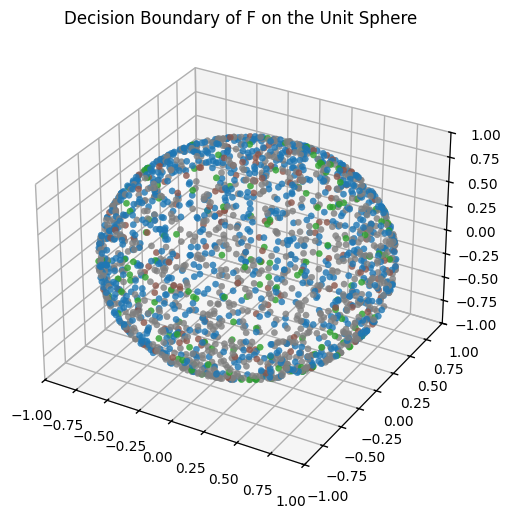

In [194]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Visualization for 3D case
def visualize_3d(z_pre, z_post, anchor):
    fig = plt.figure(figsize=(12, 6))
    
    # Pre-rotation
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(z_pre[:,0], z_pre[:,1], z_pre[:,2], alpha=0.6)
    ax1.quiver(0, 0, 0, 1, 0, 0, color='r', lw=2, label='Original Direction')
    ax1.set_title('Pre-Rotation Samples')
    ax1.set_xlim(-1,1); ax1.set_ylim(-1,1); ax1.set_zlim(-1,1)
    
    # Post-rotation
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(z_post[:,0], z_post[:,1], z_post[:,2], alpha=0.6, c='orange')
    # ax2.quiver(0, 0, 0, *anchor, color='g', lw=2, label='Target Anchor')
    ax2.set_title(f'Post-Rotation Samples (κ=50)')
    ax2.set_xlim(-1,1); ax2.set_ylim(-1,1); ax2.set_zlim(-1,1)
    
    plt.tight_layout()
    plt.show()
    
def get_colors_by_composite_labels(labels: np.ndarray):
    """
    Assign colors based on composite labels (arrays of size 3).
    Each unique combination of 3 values gets the same color.
    
    Args:
        labels: numpy array of shape (batch, 3) where each row is a composite label
        
    Returns:
        List of color strings in hex format
    """
    cmap = matplotlib.colormaps['Set1']
    color_palette = cmap(np.linspace(0, 1, 3)) # number of doors
    
    # Convert each composite label to a tuple (hashable) for dictionary keys
    label_tuples = [tuple(label) for label in labels]
    unique_labels = list(set(label_tuples))  # Get unique composite labels
    
    # Create mapping from composite label to color
    label_to_color = {label: color_palette[i % len(color_palette)] 
                    for i, label in enumerate(unique_labels)}
    
    # Generate color array
    colors = [label_to_color[tuple(label)] for label in labels]
    
    return colors

def visualize_dynamics(z_pres, z_posts, anchor, z_colors, colors):
    fig = plt.figure(figsize=(12, 6))
    anchor = (anchor / jnp.linalg.norm(anchor, axis=-1, keepdims=True))
    ax1 = fig.add_subplot(111, projection='3d')
    for i in range(z_pres.shape[0]):
        ax1.scatter(z_pres[i,:, 0], z_pres[i,:, 1], z_pres[i, :, 2], alpha=0.6, c=z_colors[i])#c[i])
    for i in range(1, colors.shape[0]):
        ax1.quiver(0, 0, 0, *anchor[i], color=colors[i], lw=2)
    ax1.set_title('Pre-Rotation Samples')
    ax1.set_xlim(-1,1); ax1.set_ylim(-1,1); ax1.set_zlim(-1,1)
    
    plt.tight_layout()
    plt.show()

def project_z(z):
    return z / jnp.linalg.norm(z, axis=-1, keepdims=True)

def sample_z(batch_size, latent_dim, key):
    z = jax.random.normal(shape=(batch_size, latent_dim), key=key)
    return z

layouts_to_viz = 1

final_indices = np.cumsum(jnp.array([layouts_for_embeddings[i]['traj_states'].shape[0] for i in range(layouts_to_viz)]))
samples_from_trajs = []
prev_inxs = 0
for i in range(len(final_indices)):
    cur_sel = np.random.choice(np.arange(prev_inxs, final_indices[i]), size=35)
    samples_from_trajs.append(cur_sel)
    prev_inxs = final_indices[i] + 1
    
samples_from_trajs_indxs = np.stack(samples_from_trajs).reshape(-1)
    
key = jax.random.PRNGKey(0)
one_hot_labels = np.concatenate([layouts_for_embeddings[i]['layout_type'] for i in range(NUM_TRAIN_LAYOUTS)])
obses = np.concatenate([layouts_for_embeddings[i]['observations'] for i in range(NUM_TRAIN_LAYOUTS)])
next_obses = np.concatenate([layouts_for_embeddings[i]['next_observations'] for i in range(NUM_TRAIN_LAYOUTS)])
actions = np.concatenate([layouts_for_embeddings[i]['actions'] for i in range(NUM_TRAIN_LAYOUTS)])[:, None]

sphere_directions = sample_z(2048, fb_config['agent']['z_dim'], GLOBAL_KEY)
projected_sphere_dirs = project_z(PCA(3).fit_transform(sphere_directions))

tsne = one_hot_labels[samples_from_trajs_indxs]
# z = fb_agent.sample_mixed_z(batch, fb_config['agent']['z_dim'], GLOBAL_KEY)
# z = fb_agent.network.select('b_value')(obses[samples_from_trajs_indxs])#, one_hot_labels) # GOALS goal[None]
#obses[samples_from_trajs_indxs][2][None]
# tsne[2][None]
F1, F2 = fb_agent.network.select('f_value')(jnp.repeat(jnp.array([4, 1])[None], repeats=sphere_directions.shape[0], axis=0), 
                                        sphere_directions, jnp.repeat(layout_types[2][None], repeats=sphere_directions.shape[0], axis=0))
Q1 = jnp.einsum('sda, sd -> sa', F1, sphere_directions)
Q2 = jnp.einsum('sda, sd -> sa', F2, sphere_directions)
Q = jnp.minimum(Q1, Q2)
best_actions = jnp.argmax(Q, axis=-1)


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap('tab10')
colors = cmap(best_actions / 4)
ax.scatter(
    projected_sphere_dirs[:, 0],
    projected_sphere_dirs[:, 1],
    projected_sphere_dirs[:, 2],
    c=colors,
    s=20,
    alpha=0.8
)
ax.set_title('Decision Boundary of F on the Unit Sphere')
ax.set_xlim(-1, 1); ax.set_ylim(-1, 1); ax.set_zlim(-1, 1)
plt.show()

""

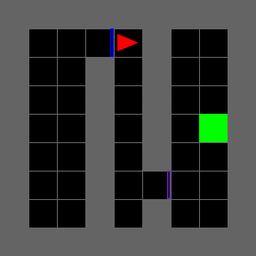

In [193]:
from envs.minigrid.doors_grid import DynamicsGeneralization_Doors, MinigridWrapper

# Train dynamics
layouts = []
env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=100, task_num=0, agent_start_pos=(4, 1))
env._gen_grid = partial(env._gen_grid, layout_type=2)
env = MinigridWrapper(env)
# env = ActionRepeatWrapper(env, action_repeat=3) # test
env.reset()

layouts.append(env.render())
    
mediapy.show_images(layouts, width=256, height=256)

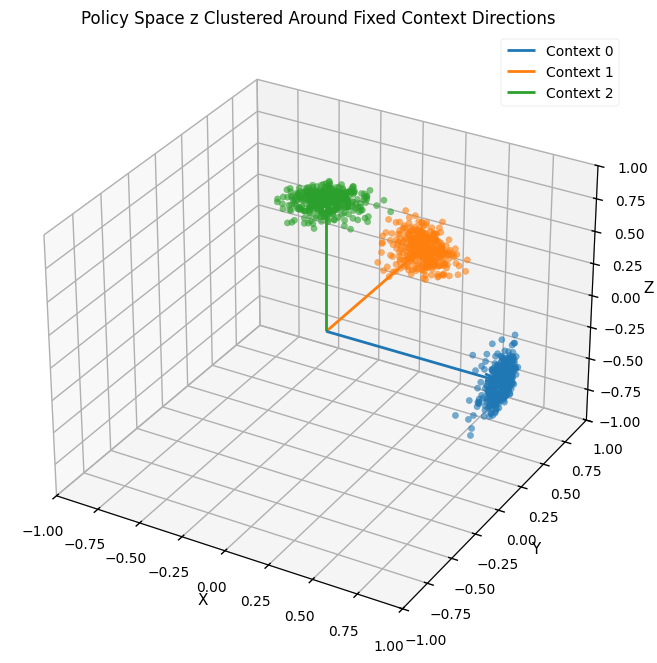

In [14]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def visualize_context_alignment(z_values, context_labels, context_vectors):
    """
    Visualize how z-values cluster around fixed context directions.
    
    Args:
        z_values (np.ndarray): (N, 3) sampled z-values (normalized).
        context_labels (np.ndarray): (N,) integer labels for contexts.
        context_vectors (np.ndarray): (C, 3) fixed direction vectors.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot z-values colored by context
    colors = cm.tab10(context_labels % 10)  # Assign colors to contexts
    ax.scatter(z_values[:,0], z_values[:,1], z_values[:,2], 
            c=colors, alpha=0.6, s=20, depthshade=False)
    
    # Plot fixed context directions
    for i, vec in enumerate(context_vectors):
        ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], 
                color=cm.tab10(i % 10), lw=2, 
                label=f'Context {i}', arrow_length_ratio=0.1)
    
    ax.set_xlim(-1, 1); ax.set_ylim(-1, 1); ax.set_zlim(-1, 1)
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.legend()
    plt.title("Policy Space z Clustered Around Fixed Context Directions")
    plt.show()

# Simulate data (replace with your actual z-values and contexts)
context_vectors = np.eye(3)  # Fixed directions for 3 layouts
context_labels = np.random.randint(0, 3, 1000)  # Random context assignments

# Generate z-values clustered near their context directions
z_values = []
for label in context_labels:
    base = context_vectors[label]
    noise = 0.1 * np.random.randn(3)  # Add small noise
    z = base + noise
    z_values.append(z / np.linalg.norm(z))  # Normalize to unit sphere
z_values = np.array(z_values)

visualize_context_alignment(z_values, context_labels, context_vectors)

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D visualization

def sample_z_nd(batch_size, dim, key, custom_anchor, kappa=20):
    """
    N-dimensional version with von Mises-Fisher sampling and rotation.
    Returns pre-rotation and post-rotation z vectors.
    """
    # Normalize anchor
    anchor = custom_anchor / jnp.linalg.norm(custom_anchor)
    
    # 1. Generate samples around north pole [1, 0, ..., 0]
    # Using von Mises-Fisher sampling in n-dimensions
    samples = _vmf_sample_north_pole(key, batch_size, dim, kappa)
    
    # 2. Create Householder rotation matrix
    rotation = _nd_householder_rotation(anchor)
    
    # 3. Rotate samples to align with anchor
    z_pre = samples
    z_post = jnp.einsum('ij,bj->bi', rotation, z_pre)
    
    return z_pre, z_post, anchor

def _vmf_sample_north_pole(key, batch_size, dim, kappa):
    """Von Mises-Fisher sampling around [1,0,...0] with proper 2D handling"""
    if dim == 2:
        # Von Mises-Fisher sampling (2D version)
        theta = jnp.linspace(0, 2*jnp.pi, 1000)  # Angle basis
        w = jnp.cos(theta)  # Projection onto anchor direction
        
        # Sample angles weighted by von Mises-Fisher
        weights = jnp.exp(kappa * w)  # Unnormalized PDF
        samples = jax.random.choice(key, theta, shape=(batch_size,), p=weights/weights.sum())
        
        # Create pre-rotation vectors on unit circle
        z_pre = jnp.column_stack([jnp.cos(samples), jnp.sin(samples)])
        return z_pre
    else:
        # Wood's algorithm for dimensions >= 3
        v_key, w_key = jax.random.split(key)
        
        # Step 1: Sample uniform from S^{d-2}
        uniform_samples = jax.random.normal(v_key, (batch_size, dim-1))
        uniform_samples /= jnp.linalg.norm(uniform_samples, axis=-1, keepdims=True)
        
        # Step 2: Sample radial component (corrected implementation)
        b = (-2*kappa + jnp.sqrt(4*kappa**2 + (dim-1)**2)) / (dim-1)
        t = jax.random.beta(w_key, (dim-1)/2, (dim-1)/2, (batch_size,))
        
        # Compute w using full Wood's formula
        numerator = 1 - (1 + b) * t
        denominator = 1 - (1 - b) * t
        w = numerator / denominator
        
        # Combine components
        w = w[..., jnp.newaxis]
        v = jnp.sqrt(1 - w**2) * uniform_samples
        return jnp.concatenate([w, v], axis=-1)

def _nd_householder_rotation(anchor):
    """Householder rotation to align [1,0,...0] with arbitrary anchor"""
    e = jnp.zeros_like(anchor).at[0].set(1.0)
    u = e - anchor
    u_norm = u / jnp.linalg.norm(u)
    return jnp.eye(anchor.shape[0]) - 2 * jnp.outer(u_norm, u_norm)

# Visualization for 3D case
def visualize_3d(z_pre, z_post, anchor):
    fig = plt.figure(figsize=(12, 6))
    
    # Pre-rotation
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(z_pre[:,0], z_pre[:,1], z_pre[:,2], alpha=0.6)
    ax1.quiver(0, 0, 0, 1, 0, 0, color='r', lw=2, label='Original Direction')
    ax1.set_title('Pre-Rotation Samples')
    ax1.set_xlim(-1,1); ax1.set_ylim(-1,1); ax1.set_zlim(-1,1)
    
    # Post-rotation
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(z_post[:,0], z_post[:,1], z_post[:,2], alpha=0.6, c='orange')
    ax2.quiver(0, 0, 0, *anchor, color='g', lw=2, label='Target Anchor')
    ax2.set_title(f'Post-Rotation Samples (κ=50)')
    ax2.set_xlim(-1,1); ax2.set_ylim(-1,1); ax2.set_zlim(-1,1)
    
    plt.tight_layout()
    plt.show()

def visualize_2d(z_pre, z_post, anchor):
    fig = plt.figure(figsize=(12, 6))
    
    # Pre-rotation
    ax1 = fig.add_subplot(121)
    ax1.scatter(z_pre[:,0], z_pre[:,1], alpha=0.6)
    ax1.quiver(0, 0, 1, 0, color='r', scale=1, scale_units='xy', angles='xy', 
            width=0.01, label='Original Direction')
    ax1.set_title('Pre-Rotation Samples')
    ax1.set_xlim(-1.1,1.1); ax1.set_ylim(-1.1,1.1)
    ax1.set_aspect('equal')
    ax1.grid(True)
    ax1.legend()
    
    # Post-rotation
    ax2 = fig.add_subplot(122)
    ax2.scatter(z_post[:,0], z_post[:,1], alpha=0.6, c='orange')
    ax2.quiver(0, 0, anchor[0], anchor[1], color='g', scale=1, 
            scale_units='xy', angles='xy', width=0.01, label='Target Anchor')
    ax2.set_title(f'Post-Rotation Samples')
    ax2.set_xlim(-1.1,1.1); ax2.set_ylim(-1.1,1.1)
    ax2.set_aspect('equal')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def visualize_dynamics(z_pres, z_posts, anchor):
    fig = plt.figure(figsize=(12, 6))
    
    # Pre-rotation
    ax1 = fig.add_subplot(121, projection='3d')
    for i, color in zip(range(z_pres.shape[0]), ['red', 'green', 'orange']):
        ax1.scatter(z_pres[i, :,0], z_pres[i, :,1], z_pres[i, :,2], alpha=0.6, c=color)
    ax1.quiver(0, 0, 0, 1, 0, 0, color='orange', lw=2)
    ax1.quiver(0, 0, 0, 0, 1, 0, color='green', lw=2)
    ax1.quiver(0, 0, 0, 0, 0, 1, color='red', lw=2)
    ax1.set_title('Pre-Rotation Samples')
    ax1.set_xlim(-1,1); ax1.set_ylim(-1,1); ax1.set_zlim(-1,1)
    
    # # Post-rotation
    ax2 = fig.add_subplot(122, projection='3d')
    for i, color in zip(range(z_posts.shape[0]), ['red', 'green', 'orange']):
        ax2.scatter(z_posts[i, :,0], z_posts[i, :,1],  z_posts[i, :,2], alpha=0.6, c=color)
    ax2.quiver(0, 0, 0, 1, 0, 0, color='orange', lw=2)
    ax2.quiver(0, 0, 0, 0, 1, 0, color='green', lw=2)
    ax2.quiver(0, 0, 0, 0, 0, 1, color='red', lw=2)
    ax2.set_title(f'Post-Rotation Samples (κ=50)')
    ax2.set_xlim(-1,1); ax2.set_ylim(-1,1); ax2.set_zlim(-1,1)
    
    plt.tight_layout()
    plt.show()

# Example usage for 3D
key = jax.random.PRNGKey(0)
custom_anchor_3d = jnp.array([0.5, 0.5, 0])  # Must be unit vector
custom_anchor_2d = jnp.array([-1, 0.5])
z_pre, z_post, anchor = sample_z_nd(1000, 3, key, custom_anchor_3d, kappa=80)
visualize_3d(z_pre, z_post, anchor)
# visualize_2d(z_pre, z_post, anchor)

In [ ]:
anchors = [
    jnp.array([1.0, -1.5, 0.0]),  # Dynamics type 1
    jnp.array([1, 1, 1]),  # Dynamics type 2
    jnp.array([-1, -1.0, 1.0]),  # Dynamics type 3
]
zs_post = []
zs_pre = []
for i in range(3):
    key = jax.random.fold_in(key, i)
    z_pre, z_post, anchor = sample_z_nd(1000, 3, key, anchors[i], kappa=100)
    zs_post.append(z_post)
    zs_pre.append(z_pre)
    
visualize_dynamics(jnp.stack(zs_pre), jnp.stack(zs_post), anchor=anchors)

# Test zero-shot

In [ ]:
env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=NUM_TRAIN_STEPS, agent_start_pos=(1, 4))
env._gen_grid = partial(env._gen_grid, layout_type=18) # not seen during training
env = MinigridWrapper(env)

all_obses = []
all_actions = []
all_next_obses = []

renders = []
for i in range(1):
    renders = []
    obs, _ = env.reset()
    reward=0
    done = False
    obses = []
    actions = []
    next_obses = []
    step = 0
    while step < NUM_TRAIN_STEPS:
        step += 1
        obses.append(np.array(obs))
        action = env.action_space.sample()
        actions.append(action[None])
        obs, rew, terminated, truncated, _ = env.step(action)
        next_obses.append(np.array(obs))
        renders.append(env.render())
        
    all_obses.append(np.stack(obses))
    all_actions.append(np.stack(actions))
    all_next_obses.append(np.stack(next_obses))
    
obses = np.stack(all_obses)
actions = np.stack(all_actions)
next_obses = np.stack(all_next_obses)

mediapy.show_video(
    renders
)

In [ ]:
plot_layouts = []
for i in range(NUM_TRAIN_LAYOUTS):
    cur_layout = gc_whole_dataset.sample(512, layout_type=i, context_length=NUM_TRAIN_STEPS)[1]
    plot_layouts.append(cur_layout)
    
plot_layouts = functools.reduce(concatenate_dicts, plot_layouts)

cmap = matplotlib.colormaps['Set1']
c = cmap(np.linspace(0, 1, 7)) # number of doors
layouts_for_embeddings = []
colors = []
for i in range(1, 7):
    cur_layout_indx = jnp.where(jnp.any((plot_layouts['traj_states'][:, :, 0] == 3.0) & (plot_layouts['traj_states'][:, :, 1] == i), 1))[0]
    cur_layout_traj = jax.tree_util.tree_map(lambda arr: arr[cur_layout_indx], plot_layouts)
    if len(cur_layout_indx) > 1:
        layouts_for_embeddings.append(cur_layout_traj)
        colors.append([c[i]] * cur_layout_traj['traj_actions'].shape[0])
plot_layouts = functools.reduce(concatenate_dicts, layouts_for_embeddings)
colors = np.concatenate(colors)

In [ ]:
dynamics_embedding_mean, std = fb_agent.network.select('dynamic_transformer')(plot_layouts['traj_states'], plot_layouts['traj_actions'],
                                                                            plot_layouts['traj_next_states'], train=False)
dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=GLOBAL_KEY, shape=dynamics_embedding_mean.shape) * jnp.exp(std)
zs = fb_agent.infer_z(plot_layouts['observations'], dynamics_embedding=dynamics_embedding)

In [ ]:
import optax
def pairwise_distances(dist, xs, ys):
    return jax.vmap(lambda x: jax.vmap(lambda y: dist(x, y))(xs))(ys)
cos_dist = pairwise_distances(optax.losses.cosine_similarity, zs, zs)

In [ ]:
first_dyn_indices = jnp.where(jnp.any((plot_layouts['traj_states'][:, :, 0] == 3.0) & (plot_layouts['traj_states'][:, :, 1] == 1), 1))[0]
first_dyn = jax.tree_util.tree_map(lambda arr: arr[first_dyn_indices], plot_layouts)

sec_dyn_indices = jnp.where(jnp.any((plot_layouts['traj_states'][:, :, 0] == 3.0) & (plot_layouts['traj_states'][:, :, 1] == 2), 1))[0]
sec_dyn = jax.tree_util.tree_map(lambda arr: arr[sec_dyn_indices], plot_layouts)

In [ ]:
plt.plot(range(len(first_dyn_indices)), cos_dist[0, first_dyn_indices], c='blue')
plt.plot(range(270, 608), cos_dist[0, sec_dyn_indices], c='green')

In [ ]:
plt.plot(range(len(first_dyn_indices)), cos_dist[500, first_dyn_indices], c='blue')
plt.plot(range(270, 608), cos_dist[500, sec_dyn_indices], c='green')

In [ ]:
from sklearn.manifold import TSNE

all_boxes_obs_test = np.concatenate([plot_layouts['traj_states'], obses])
all_boxes_actions_test = np.concatenate([plot_layouts['traj_actions'], actions])
all_boxes_nobs_test = np.concatenate([plot_layouts['traj_next_states'], next_obses])

dynamics_embedding_mean, std = fb_agent.network.select('dynamic_transformer')(all_boxes_obs_test, all_boxes_actions_test,
                                                                            all_boxes_nobs_test, train=False)

dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=GLOBAL_KEY, shape=dynamics_embedding_mean.shape) * jnp.exp(std)
tsne = TSNE(random_state=42).fit_transform(dynamics_embedding)
black_rgb = matplotlib.colors.to_rgba('black')
black_colors = [black_rgb] * obses.shape[0]

final_colors = np.concatenate([
    colors,
    black_colors
])
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(tsne[:, 0], tsne[:, 1], 
            edgecolors='black',
            c=final_colors)

In [ ]:
fig, ax = plt.subplots()
pred_policy_img = visualize_policy_image(layout_type=5, task_num=0)
ax.imshow(pred_policy_img)